In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/gdrive')





Mounted at /content/gdrive


In [ ]:
# Try different encodings
try:
    df  = pd.read_csv('/content/gdrive/MyDrive/hwda02/data/Processed_COVID_Data_Filled.csv', encoding='cp949')
except UnicodeDecodeError:
    try:
        df  = pd.read_csv('/content/gdrive/MyDrive/hwda02/data/Processed_COVID_Data_Filled.csv', encoding='latin-1')
    except UnicodeDecodeError:
        try:
            df  = pd.read_csv('/content/gdrive/MyDrive/hwda02/data/Processed_COVID_Data_Filled.csv', encoding='cp1252')
        except UnicodeDecodeError:
            print("Could not decode file with common encodings. Please check the encoding of your file.")
            raise  # Re-raise the error if none of the encodings work


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 회귀 모델 & 검증용
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import matplotlib.font_manager as fm
# font_name = fm.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name()
# plt.rc('font', family=font_name)


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Statsmodels: SARIMAX 모델링
import statsmodels.api as sm

# TensorFlow / Keras: LSTM 모델링
import tensorflow as tf
from tensorflow import keras

In [ ]:
# ===============================
# 2. 데이터 전처리: 날짜 변환 및 정렬, 기본 정보 출력
# ===============================
# 'Date' 컬럼을 datetime 타입으로 변환 (변환 실패 시 NaT 발생)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')

# 날짜 기준으로 오름차순 정렬 및 인덱스 재설정
df = df.sort_values('Date').reset_index(drop=True)

# 데이터의 상위 5행, 정보, 기술 통계 출력
print("=== 데이터 상위 5행 ===")
print(df.head(), "\n")
print("=== 데이터 정보 ===")
print(df.info(), "\n")
print("=== 기술 통계 요약 ===")
print(df.describe(), "\n")

=== 데이터 상위 5행 ===
        Date  Cases       SO2        CO        O3       NO2       PM10  \
0 2020-02-01      0  0.003274  0.699089  0.026038  0.022698  63.185218   
1 2020-02-02      0  0.003502  0.748826  0.028493  0.020737  69.092334   
2 2020-02-03      0  0.003140  0.463362  0.029590  0.015894  32.560316   
3 2020-02-04      3  0.003329  0.465114  0.023674  0.019638  29.410079   
4 2020-02-05      3  0.003002  0.374520  0.029291  0.011450  22.960480   

        PM25  평균기온(℃)  평균최고기온(℃)  ...  최저기온(℃)  평균일강수량(mm)  최다일강수량(mm)  \
0  47.416719      2.2        7.8  ...     -6.8         0.0         0.2   
1  52.897434      2.1        7.8  ...    -11.2         0.0         0.7   
2  21.600817      1.3        5.7  ...     -9.7         0.0         0.7   
3  18.842018      0.1        6.3  ...    -18.6         0.3         2.0   
4  11.594881     -3.6        1.0  ...    -18.9         0.0        26.0   

   평균풍속(m/s)  최대풍속(m/s)  최대순간풍속(m/s)  평균습도(%rh)  최저습도(%rh)  일조합(hr)  \
0        1.5       12

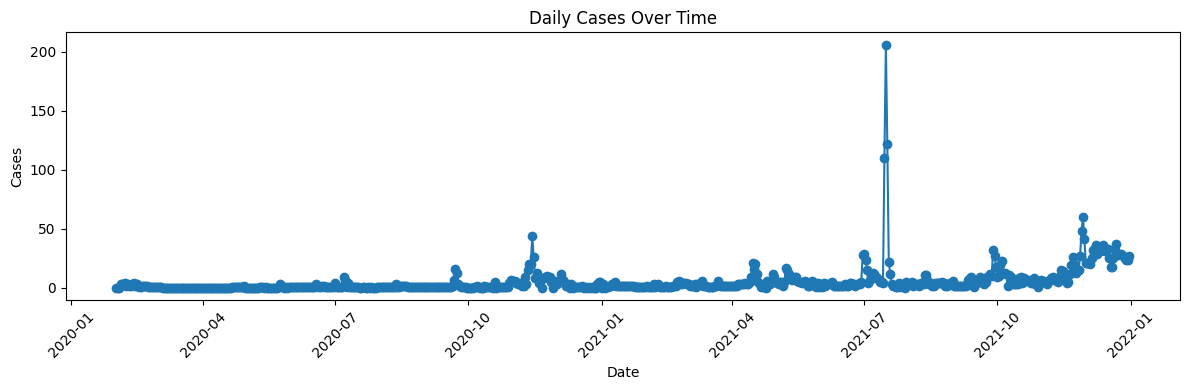

In [ ]:
# ===============================
# 3. EDA: 시간에 따른 'Cases' 변화 및 상관관계 히트맵 시각화
# ===============================
# 날짜별 Cases 변화를 선 그래프로 시각화
plt.figure(figsize=(12, 4))
plt.plot(df['Date'], df['Cases'], marker='o', linestyle='-')
plt.title('Daily Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/u

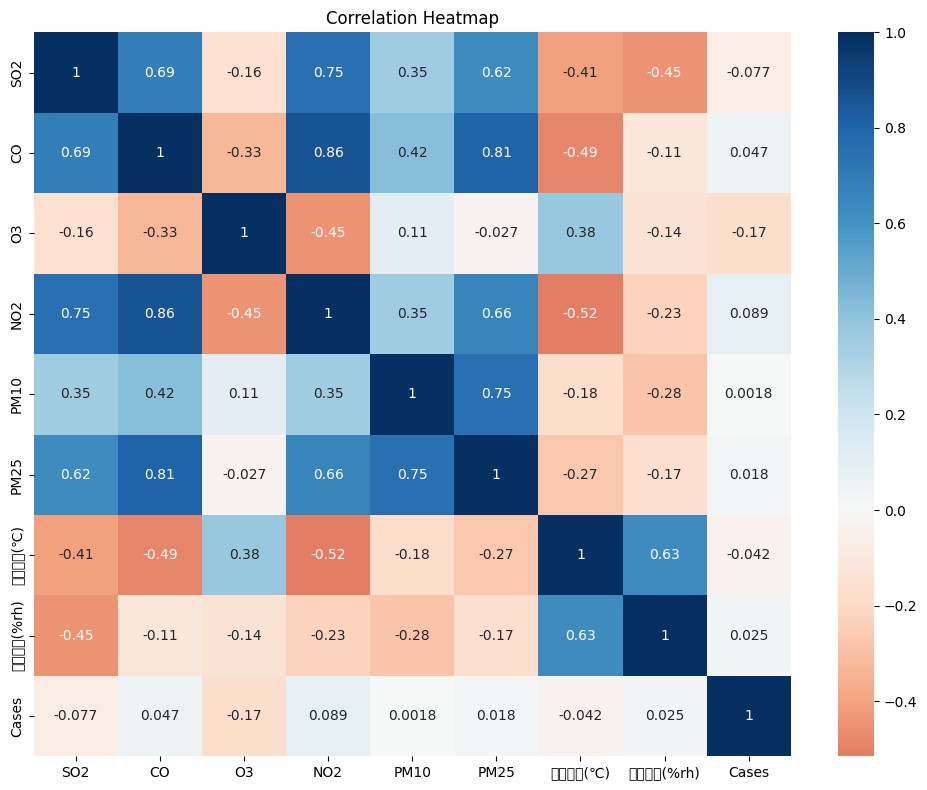

In [ ]:
# 상관관계 분석을 위한 컬럼 선택 및 히트맵 시각화
corr_columns = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)','평균습도(%rh)','Cases']
plt.figure(figsize=(10,8))
sns.heatmap(df[corr_columns].corr(), annot=True, cmap='RdBu', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


In [ ]:
# ===============================
# 4. 특징 공학 (Feature Engineering): Lag Feature 생성 및 결측치 제거
# ===============================
# 'Cases' 변수에 대해 1일 전(lag1)과 7일 전(lag7) 값을 새로운 컬럼으로 추가
# (함수를 사용하지 않고 직접 for-loop 대신 반복문 없이 각각 추가)
df['Cases_lag1'] = df['Cases'].shift(1)
df['Cases_lag7'] = df['Cases'].shift(7)

# Lag feature 생성 후 결측치가 발생한 첫 7행 제거 및 인덱스 재설정
df = df.dropna().reset_index(drop=True)

In [ ]:
# ===============================
# 5. 데이터 분할: Train / Test (날짜 기준)
# ===============================
# 분석 목표: 과거 데이터를 이용하여 미래의 'Cases' 예측
# 여기서는 '2021-05-01'을 기준으로 훈련/테스트 데이터 분할
cutoff_date = pd.to_datetime('2021-05-01')
train_df = df[df['Date'] < cutoff_date].copy()
test_df  = df[df['Date'] >= cutoff_date].copy()
print("Train 데이터 크기:", train_df.shape)
print("Test 데이터 크기:", test_df.shape)

Train 데이터 크기: (448, 24)
Test 데이터 크기: (245, 24)


In [ ]:
# ===============================
# 6. 랜덤 포레스트 회귀 모델: 모델 학습 및 평가
# ===============================
# 사용할 feature 컬럼 정의 (환경/기상 변수와 lag feature 포함)
rf_features = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)','평균습도(%rh)','Cases_lag1','Cases_lag7']

# 분할된 train, test 데이터에서 feature와 타겟 추출
X_train_rf = train_df[rf_features]
y_train_rf = train_df['Cases']
X_test_rf  = test_df[rf_features]
y_test_rf  = test_df['Cases']

# 기본 랜덤 포레스트 모델을 위한 하이퍼파라미터 그리드 설정
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 3, 5]
}

# TimeSeriesSplit을 사용하여 시계열 특성을 고려한 교차검증 수행
tscv = TimeSeriesSplit(n_splits=3)

print("\n랜덤 포레스트 모델을 위한 GridSearchCV 진행...")
rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=rf_param_grid,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train_rf, y_train_rf)
print("최적 파라미터 (RandomForest):", rf_grid.best_params_)
print("최적 CV 스코어 (neg MAE):", rf_grid.best_score_)

# 최적 모델로 테스트 데이터 예측
best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test_rf)

# 평가 지표 계산
rf_mae = mean_absolute_error(y_test_rf, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
rf_r2 = r2_score(y_test_rf, y_pred_rf)
print(f"\n[랜덤 포레스트 평가 결과]\nMAE: {rf_mae:.4f}\nRMSE: {rf_rmse:.4f}\nR2: {rf_r2:.4f}")



랜덤 포레스트 모델을 위한 GridSearchCV 진행...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
최적 파라미터 (RandomForest): {'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 100}
최적 CV 스코어 (neg MAE): -1.5850974207117587

[랜덤 포레스트 평가 결과]
MAE: 5.4156
RMSE: 16.4830
R2: 0.2226


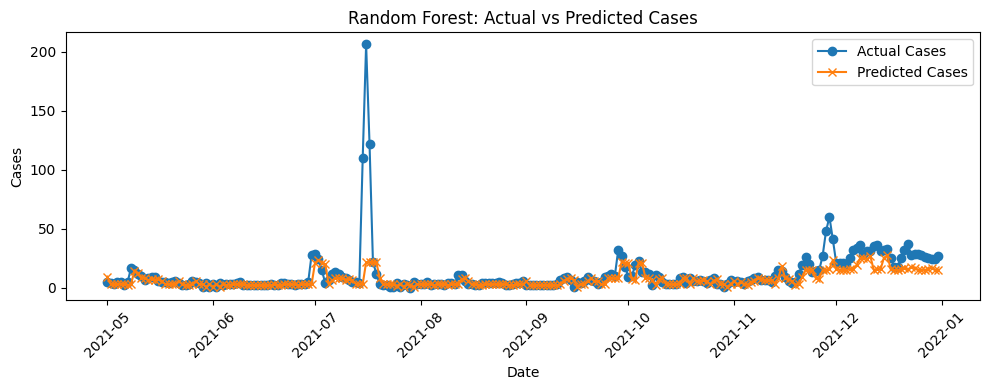

In [ ]:
# 테스트 데이터의 실제값과 예측값 시각화
plt.figure(figsize=(10,4))
plt.plot(test_df['Date'], y_test_rf, label='Actual Cases', marker='o')
plt.plot(test_df['Date'], y_pred_rf, label='Predicted Cases', marker='x')
plt.title("Random Forest: Actual vs Predicted Cases")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

<ipython-input-17-20c42f866b2e>:7: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-20c42f866b2e>:7: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-20c42f866b2e>:7: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-20c42f866b2e>:7: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-20c42f866b2e>:7: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-20c42f866b2e>:7: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaV

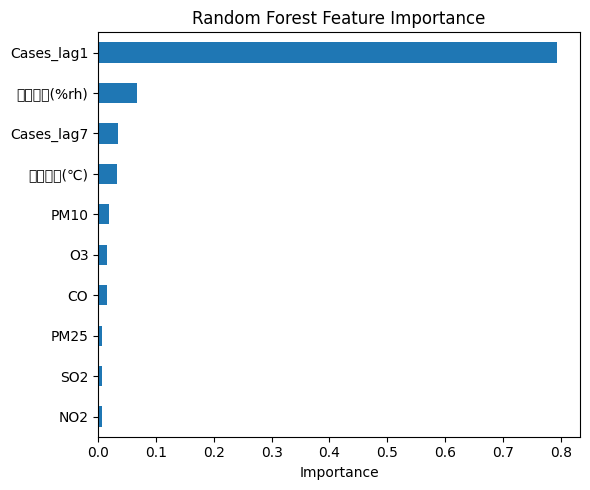

In [ ]:
# 피처 중요도 시각화
rf_feature_importance = pd.Series(best_rf.feature_importances_, index=rf_features).sort_values()
plt.figure(figsize=(6,5))
rf_feature_importance.plot(kind='barh')
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
# ===============================
# 7. SARIMAX (ARIMAX) 모델: 외생변수 포함 시계열 모델
# ===============================
# 모델에 사용할 외생변수 (lag feature 포함)
sarimax_exog = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)','평균습도(%rh)','Cases_lag1','Cases_lag7']

# 훈련/테스트 데이터에서 타겟 및 외생변수 추출
y_train_sarimax = train_df['Cases']
y_test_sarimax = test_df['Cases']
X_train_exog = train_df[sarimax_exog]
X_test_exog  = test_df[sarimax_exog]

# SARIMAX 모델 설정: (p, d, q) 및 계절성 없음
sarimax_order = (1, 0, 1)
seasonal_order = (0, 0, 0, 0)

print("\nSARIMAX 모델 학습 시작...")
sarimax_model = sm.tsa.statespace.SARIMAX(
    endog=y_train_sarimax,
    exog=X_train_exog,
    order=sarimax_order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_results = sarimax_model.fit(disp=False)
print(sarimax_results.summary())


SARIMAX 모델 학습 시작...
                               SARIMAX Results                                
Dep. Variable:                  Cases   No. Observations:                  448
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1023.056
Date:                Mon, 03 Feb 2025   AIC                           2072.113
Time:                        00:42:28   BIC                           2125.417
Sample:                             0   HQIC                          2093.130
                                - 448                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SO2          -32.5210    846.854     -0.038      0.969   -1692.325    1627.283
CO            -2.4822      8.068     -0.308      0.758     -18.296      13.331
O3             3.3612     24.76

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# 테스트 데이터에 대해 예측
n_test = len(y_test_sarimax)
pred_sarimax = sarimax_results.predict(
    start=len(y_train_sarimax),
    end=len(y_train_sarimax) + n_test - 1,
    exog=X_test_exog
)

# 평가 지표 계산
sarimax_mae = mean_absolute_error(y_test_sarimax, pred_sarimax)
sarimax_rmse = np.sqrt(mean_squared_error(y_test_sarimax, pred_sarimax))
print(f"\n[SARIMAX 평가 결과]\nMAE: {sarimax_mae:.4f}\nRMSE: {sarimax_rmse:.4f}")


[SARIMAX 평가 결과]
MAE: 4.3844
RMSE: 12.5792


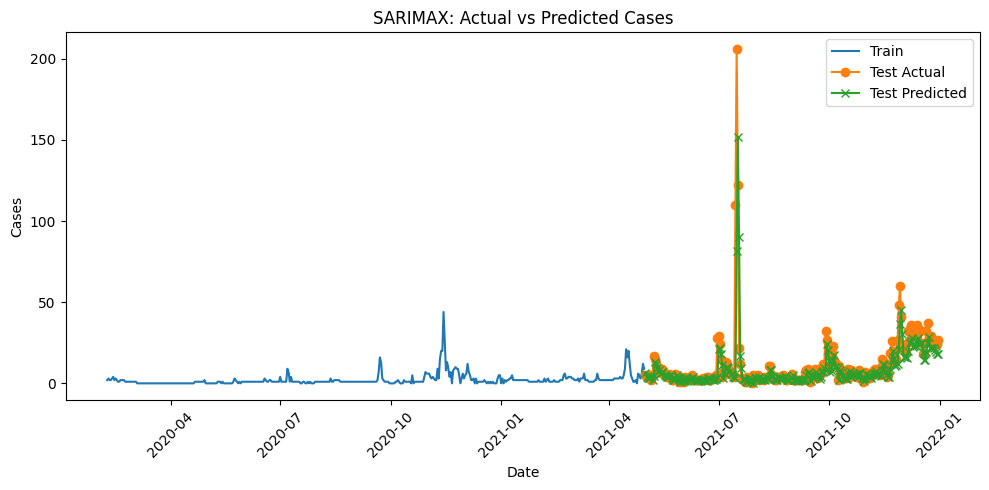

In [ ]:
# 훈련 데이터와 테스트 데이터의 실제값 및 예측값 시각화
plt.figure(figsize=(10,5))
plt.plot(train_df['Date'], y_train_sarimax, label='Train')
plt.plot(test_df['Date'], y_test_sarimax, label='Test Actual', marker='o')
plt.plot(test_df['Date'], pred_sarimax, label='Test Predicted', marker='x')
plt.title("SARIMAX: Actual vs Predicted Cases")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ===============================
# 8. LSTM 모델: 시퀀스 데이터 생성, 모델 학습 및 평가
# ===============================
# (1) LSTM에 사용할 feature 선택: 환경/기상 변수와 lag feature
lstm_features = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)','평균습도(%rh)','Cases_lag1','Cases_lag7']
X_arr = df[lstm_features].values   # 입력 데이터, shape: (N, num_features)
y_arr = df['Cases'].values           # 타겟 데이터, shape: (N,)

# (2) 데이터 스케일링: MinMaxScaler 사용
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X_arr)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y_arr.reshape(-1,1)).flatten()

# (3) 시퀀스 데이터 생성: window_size일 동안의 데이터를 입력으로 사용
# 함수 사용을 최소화하기 위해 for-loop를 직접 작성
window_size = 7
X_seq_list = []
y_seq_list = []
for i in range(len(X_scaled) - window_size):
    X_seq_list.append(X_scaled[i:i+window_size])
    y_seq_list.append(y_scaled[i+window_size])
X_seq = np.array(X_seq_list)  # shape: (N - window_size, window_size, num_features)
y_seq = np.array(y_seq_list)  # shape: (N - window_size,)

print("LSTM 시퀀스 데이터 shape:", X_seq.shape, y_seq.shape)

LSTM 시퀀스 데이터 shape: (686, 7, 10) (686,)


In [ ]:
# (4) 시계열 분할: 원본 날짜(df['Date'])를 이용하여 Train/Validation 분할
# 여기서는 '2021-05-01'을 기준으로 분할
cutoff_date_lstm = pd.to_datetime('2021-07-01')
# 원본 데이터의 인덱스 중 cutoff_date 이상인 첫 인덱스 찾기
cut_idx = df.index[df['Date'] >= cutoff_date_lstm][0]
# 시퀀스 데이터는 window_size만큼 인덱스가 뒤로 밀리므로, split_index를 조정
split_index = max(0, cut_idx - window_size)
X_train_seq = X_seq[:split_index]
y_train_seq = y_seq[:split_index]
X_test_seq  = X_seq[split_index:]
y_test_seq  = y_seq[split_index:]
print("LSTM Train shape:", X_train_seq.shape, y_train_seq.shape)
print("LSTM Test shape :", X_test_seq.shape, y_test_seq.shape)

LSTM Train shape: (502, 7, 10) (502,)
LSTM Test shape : (184, 7, 10) (184,)


In [ ]:
# (5) LSTM 모델 구축 및 학습
# 모델 구조: LSTM 레이어 + Dropout + Dense 출력 레이어
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
lstm_units = 32
dropout_rate = 0.2
learning_rate = 1e-3

lstm_model = keras.Sequential([
    keras.layers.LSTM(lstm_units, activation='tanh', return_sequences=False, input_shape=input_shape),
    keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(1)  # 출력: 단일 값 (Cases)
])
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
lstm_model.compile(optimizer=optimizer, loss='mse')
lstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 32)                  │           5,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,537 (21.63 KB)

 Trainable params: 5,537 (21.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0113 - val_loss: 0.0010
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0053 - val_loss: 0.0040
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0049 - val_loss: 8.2958e-04
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - val_loss: 7.8928e-04
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 7.3205e-04
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - val_loss: 8.2398e-04
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 8.7984e-04
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.9689e-04 - val_loss: 7.3980e-04
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.0299e-04 - val_loss: 7.5594e-04
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.0822e-04 - val_loss: 6.8300e-04
Epoch 12/20
26/26 ━━━━━━━━━

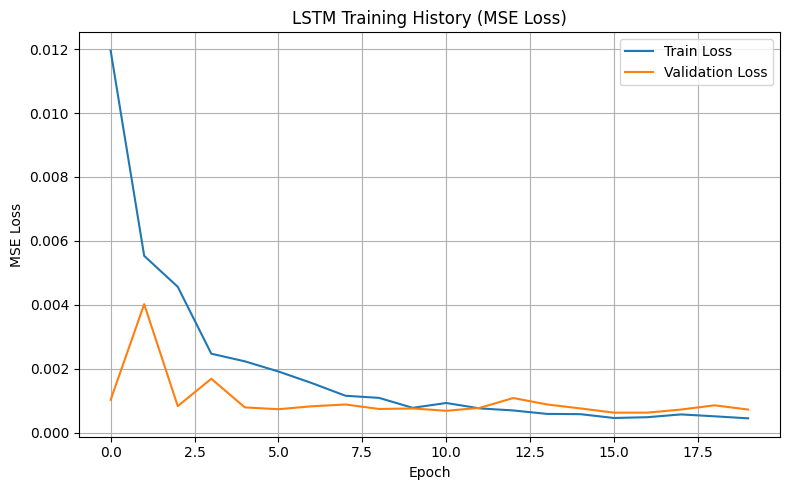

In [ ]:
# 모델 학습 (validation_split은 시간 순서를 고려하여 shuffle=False)
lstm_history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=20,
    batch_size=16,
    shuffle=False,
    verbose=1
)

# (6) 학습 기록 시각화: Loss 추이
plt.figure(figsize=(8,5))
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training History (MSE Loss)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# (7) LSTM 모델을 사용한 예측 및 평가
y_pred_lstm_scaled = lstm_model.predict(X_test_seq).flatten()
# 예측 결과와 실제값을 역스케일링하여 원래 스케일로 복원
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled.reshape(-1,1)).flatten()
y_test_lstm = scaler_y.inverse_transform(y_test_seq.reshape(-1,1)).flatten()

lstm_mae = mean_absolute_error(y_test_lstm, y_pred_lstm)
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
print(f"LSTM 평가 결과:\nMAE: {lstm_mae:.4f}\nRMSE: {lstm_rmse:.4f}")

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LSTM 평가 결과:
MAE: 9.1545
RMSE: 21.5553


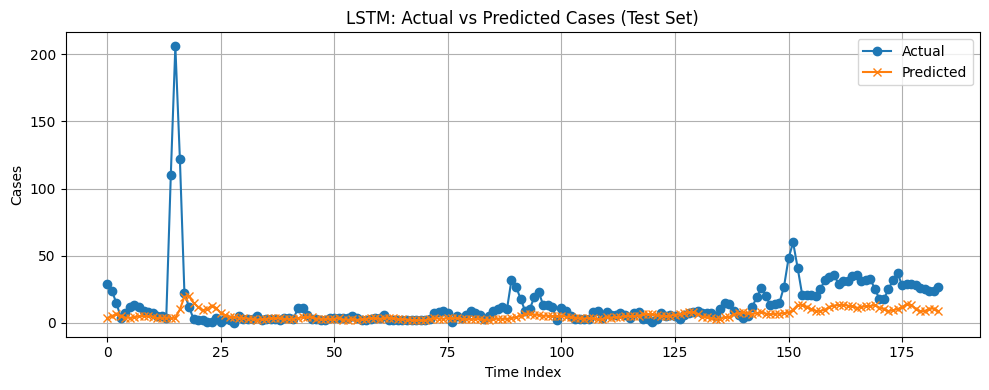

In [ ]:
# LSTM 예측 결과 시각화 (테스트 세트)
plt.figure(figsize=(10,4))
plt.plot(y_test_lstm, label='Actual', marker='o')
plt.plot(y_pred_lstm, label='Predicted', marker='x')
plt.title("LSTM: Actual vs Predicted Cases (Test Set)")
plt.xlabel("Time Index")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# ========================================
# 10. RNN 모델 (SimpleRNN) 이용 시계열 분석 코드
# ========================================
# 이 섹션에서는 이전에 스케일링 및 시퀀스 데이터(X_seq, y_seq)를 생성한 결과를 재사용합니다.
# (X_seq: (N - window_size, window_size, num_features), y_seq: (N - window_size,))
# 이미 이전 섹션(8. LSTM 모델)에서 window_size=7로 시퀀스 데이터가 생성되었습니다.

# --- (10-1) 데이터 분할 ---
# LSTM 모델과 동일하게 '2021-10-01' 기준으로 분할한 인덱스(split_index)를 사용합니다.
# (이전에 계산한 split_index 변수는 그대로 재사용합니다.)
print("RNN 모델을 위한 Train/Test 데이터 분할:")
print("LSTM Train shape:", X_train_seq.shape, y_train_seq.shape)
print("LSTM Test shape :", X_test_seq.shape, y_test_seq.shape)
# (참고: 여기서 X_train_seq, y_train_seq, X_test_seq, y_test_seq는 이미 생성되어 있습니다.)

RNN 모델을 위한 Train/Test 데이터 분할:
LSTM Train shape: (502, 7, 10) (502,)
LSTM Test shape : (184, 7, 10) (184,)


In [ ]:
# --- (10-2) RNN 모델 구축 ---
# SimpleRNN 레이어를 사용한 모델을 구성합니다.
# LSTM 모델과 마찬가지로, 입력 shape은 (window_size, num_features)입니다.
rnn_units = 32           # RNN의 은닉 유닛 수
rnn_dropout = 0.2          # 드롭아웃 비율
rnn_learning_rate = 1e-3   # 학습률

In [ ]:
# 모델 구성: SimpleRNN -> Dropout -> Dense(출력 1)
rnn_model = keras.Sequential([
    keras.layers.SimpleRNN(rnn_units, activation='tanh',
                           input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    keras.layers.Dropout(rnn_dropout),
    keras.layers.Dense(1)   # 타겟: 단일 값 (Cases)
])
rnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=rnn_learning_rate),
                  loss='mse')
print("\n=== SimpleRNN 모델 요약 ===")
rnn_model.summary()


=== SimpleRNN 모델 요약 ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 32)                  │           1,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,409 (5.50 KB)

 Trainable params: 1,409 (5.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- (10-3) RNN 모델 학습 ---
# 훈련 데이터(X_train_seq, y_train_seq)를 사용하여 모델 학습 (validation_split 적용, 시계열 순서를 유지하도록 shuffle=False)
rnn_history = rnn_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=20,
    batch_size=16,
    shuffle=False,
    verbose=1
)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.3638 - val_loss: 0.1624
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1714 - val_loss: 0.0313
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1137 - val_loss: 0.0264
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0694 - val_loss: 0.0398
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0548 - val_loss: 0.0236
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0376 - val_loss: 0.0162
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0380 - val_loss: 0.0141
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0327 - val_loss: 0.0150
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0256 - val_loss: 0.0137
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0242 - val_loss: 0.0083
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0206 - val_loss: 0.0079
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0207 - val_l

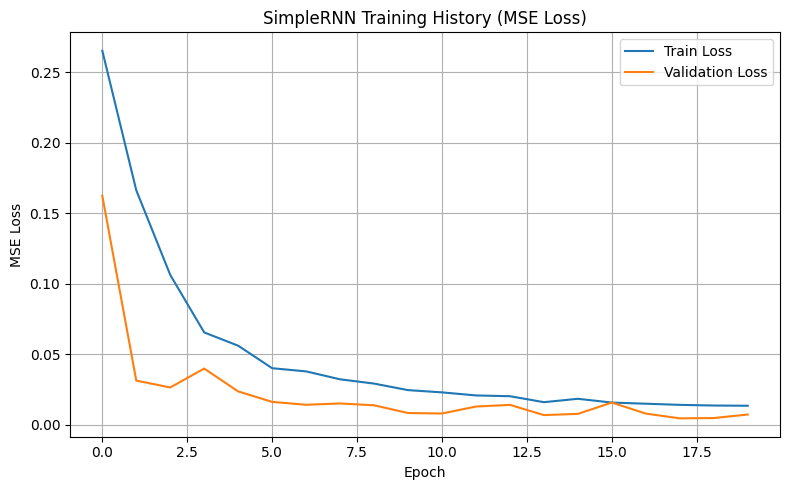

In [ ]:
# --- (10-4) 학습 기록 시각화 ---
plt.figure(figsize=(8,5))
plt.plot(rnn_history.history['loss'], label='Train Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('SimpleRNN Training History (MSE Loss)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

# --- (10-5) RNN 모델 예측 및 평가 ---
# 테스트 데이터(X_test_seq)에 대한 예측 수행
rnn_pred_scaled = rnn_model.predict(X_test_seq).flatten()

# 예측 결과와 실제 타겟(y_test_seq)은 스케일링된 값이므로,
# scaler_y (이전에 사용한 MinMaxScaler)를 이용해 원래 스케일로 복원합니다.
rnn_pred = scaler_y.inverse_transform(rnn_pred_scaled.reshape(-1,1)).flatten()
y_test_rnn = scaler_y.inverse_transform(y_test_seq.reshape(-1,1)).flatten()

# 평가 지표 계산 (MAE, RMSE)
rnn_mae = mean_absolute_error(y_test_rnn, rnn_pred)
rnn_rmse = np.sqrt(mean_squared_error(y_test_rnn, rnn_pred))
print(f"\n[SimpleRNN 평가 결과]\nMAE: {rnn_mae:.4f}\nRMSE: {rnn_rmse:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step

[SimpleRNN 평가 결과]
MAE: 21.6582
RMSE: 30.3768


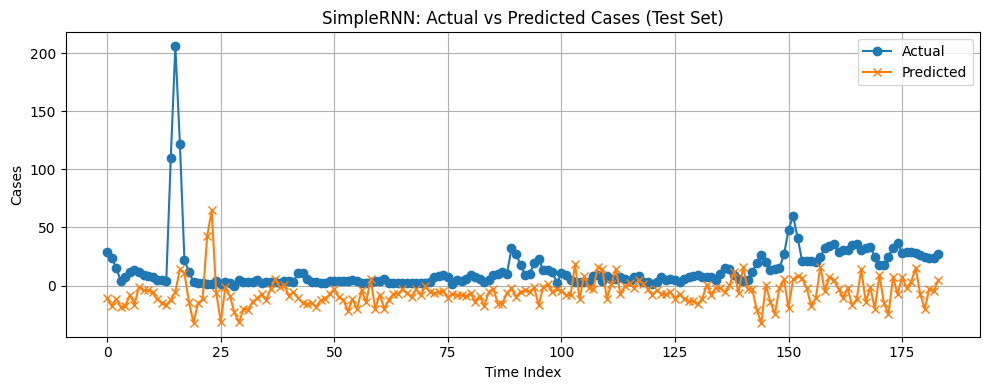

In [ ]:
# --- (10-6) RNN 예측 결과 시각화 ---
plt.figure(figsize=(10,4))
plt.plot(y_test_rnn, label='Actual', marker='o')
plt.plot(rnn_pred, label='Predicted', marker='x')
plt.title("SimpleRNN: Actual vs Predicted Cases (Test Set)")
plt.xlabel("Time Index")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ========================================
# 10. RNN 모델 코드 종료
# ========================================

In [ ]:
# ========================================
# 11. GRU 모델을 이용한 시계열 분석 코드
# ========================================
# 이 섹션에서는 이전에 전처리 및 시퀀스 데이터(X_seq, y_seq)를 생성한 결과를 재사용합니다.
# (예를 들어, window_size=7로 생성된 X_seq, y_seq가 있으며,
#  train/validation/test 분할이 이미 이루어졌다고 가정합니다.)
#
# 참고: 이전 코드에서 아래와 같이 시퀀스 데이터를 생성한 것으로 가정합니다.
#   X_seq, y_seq = create_sequence_features(X_scaled, y_scaled, window_size=7)
#   이후, 시계열 순서를 고려하여 train/validation/test 세트를 분리합니다.
#
# 여기서는 GRU 모델을 구성하고, 학습 및 평가하는 단계를 단계별로 진행합니다.

# ----------------------------
# (11-1) 데이터 분할 확인
# ----------------------------
# (이전 코드에서 생성한 변수 X_train_seq, y_train_seq, X_test_seq, y_test_seq를 재사용합니다.)
# 예시: 이미 시계열 순서를 고려하여 분할한 결과
print(">> GRU 모델을 위한 데이터 분할 결과:")
print("Train 데이터 shape:", X_train_seq.shape, y_train_seq.shape)
print("Test  데이터 shape:", X_test_seq.shape, y_test_seq.shape)


>> GRU 모델을 위한 데이터 분할 결과:
Train 데이터 shape: (502, 7, 10) (502,)
Test  데이터 shape: (184, 7, 10) (184,)


In [ ]:
# ----------------------------
# (11-2) GRU 모델 구성
# ----------------------------
# - GRU 레이어를 사용하여 시계열 패턴을 학습합니다.
# - 드롭아웃(Dropout)을 적용하여 과적합을 완화합니다.
# - Dense 레이어를 통해 최종 출력(예측 대상: Cases)을 만듭니다.
#
# 하이퍼파라미터 설정:
gru_units = 32            # GRU 레이어의 은닉 유닛 수
gru_dropout = 0.2         # 드롭아웃 비율
gru_learning_rate = 1e-3  # 학습률


In [ ]:
# GRU 모델 구성
gru_model = keras.Sequential([
    # 입력 shape: (window_size, num_features)
    keras.layers.GRU(gru_units, activation='tanh',
                     input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    # 드롭아웃 레이어: 은닉 상태의 일부를 랜덤하게 제거
    keras.layers.Dropout(gru_dropout),
    # 최종 Dense 출력 레이어: 예측값이 단일 값이므로 Dense(1)
    keras.layers.Dense(1)
])

# 모델 컴파일: 최적화 알고리즘은 Adam, 손실 함수는 MSE 사용
gru_model.compile(optimizer=keras.optimizers.Adam(learning_rate=gru_learning_rate),
                  loss='mse')

# 모델 구조 요약 출력
print("\n=== GRU 모델 요약 ===")
gru_model.summary()


=== GRU 모델 요약 ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 32)                  │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,257 (16.63 KB)

 Trainable params: 4,257 (16.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ----------------------------
# (11-3) GRU 모델 학습
# ----------------------------
# - train 데이터(X_train_seq, y_train_seq)를 사용하여 모델 학습을 수행합니다.
# - 시계열 데이터의 순서를 유지하기 위해 shuffle=False로 설정합니다.
# - validation_split=0.2로 학습 중 일부 데이터를 검증에 사용합니다.
gru_history = gru_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,   # 학습 데이터의 20%를 검증 데이터로 사용
    epochs=20,              # 에포크 수 (필요에 따라 조정 가능)
    batch_size=16,          # 배치 크기
    shuffle=False,          # 시계열 순서를 유지하기 위해 셔플하지 않음
    verbose=1
)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0340 - val_loss: 0.0324
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0302 - val_loss: 0.0024
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0079 - val_loss: 0.0024
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0065 - val_loss: 0.0031
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0062 - val_loss: 0.0017
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.00

<ipython-input-49-7f81474a42d5>:13: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-49-7f81474a42d5>:13: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-49-7f81474a42d5>:13: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-49-7f81474a42d5>:13: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-49-7f81474a42d5>:13: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-49-7f81474a42d5>:13: UserWarning: Glyph 47197 (\N{HANGUL SYLLABLE ROG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu

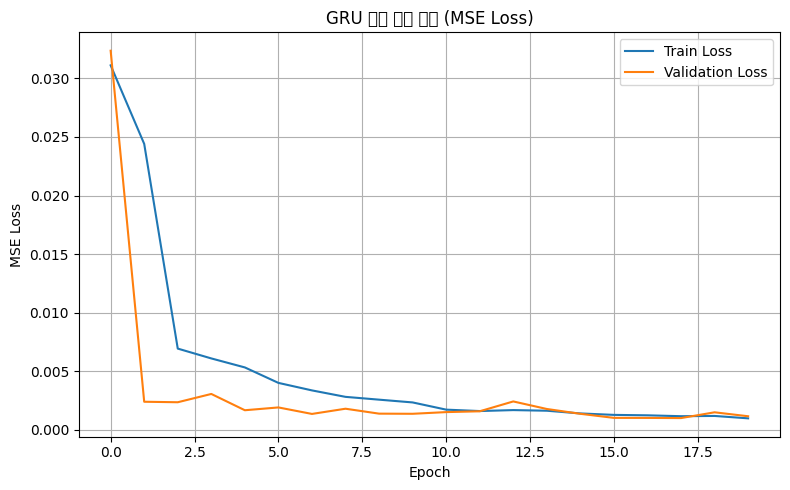

In [ ]:
# ----------------------------
# (11-4) 학습 기록 시각화
# ----------------------------
# 학습 및 검증 손실(MSE)이 에포크별로 어떻게 변화하는지 시각화합니다.
plt.figure(figsize=(8,5))
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('GRU 모델 학습 기록 (MSE Loss)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ----------------------------
# (11-5) GRU 모델 예측 및 평가
# ----------------------------
# - 테스트 데이터(X_test_seq)를 사용하여 예측을 수행합니다.
# - 예측 결과와 실제 타겟 값(y_test_seq)은 스케일링된 값입니다.
# - scaler_y (이전에 사용한 MinMaxScaler)를 사용하여 원래 스케일로 복원합니다.
gru_pred_scaled = gru_model.predict(X_test_seq).flatten()  # 스케일된 예측값
gru_pred = scaler_y.inverse_transform(gru_pred_scaled.reshape(-1,1)).flatten()  # 원래 스케일로 복원
y_test_gru = scaler_y.inverse_transform(y_test_seq.reshape(-1,1)).flatten()       # 실제 타겟 원래 스케일

# 평가 지표: MAE와 RMSE 계산
from sklearn.metrics import mean_absolute_error, mean_squared_error
gru_mae = mean_absolute_error(y_test_gru, gru_pred)
gru_rmse = np.sqrt(mean_squared_error(y_test_gru, gru_pred))
print(f"\n[GRU 모델 평가 결과]\nMAE: {gru_mae:.4f}\nRMSE: {gru_rmse:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step

[GRU 모델 평가 결과]
MAE: 8.6450
RMSE: 21.1966


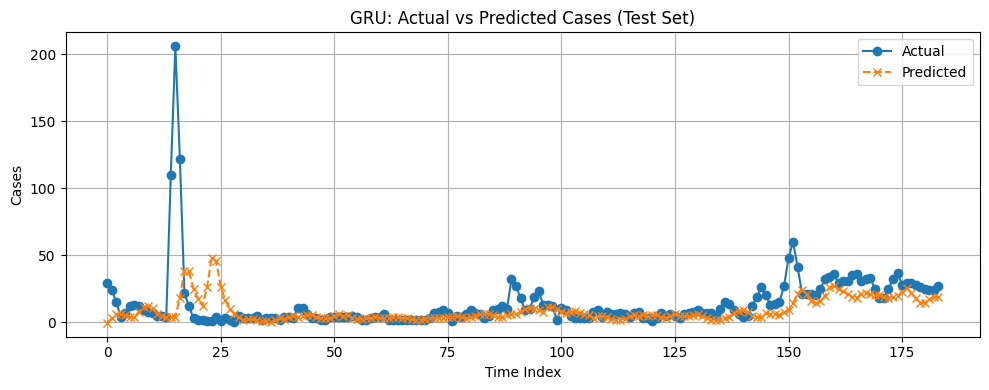

In [ ]:
# ----------------------------
# (11-6) GRU 예측 결과 시각화
# ----------------------------
# 테스트 데이터에서 실제 값과 예측 값을 비교하여 시각화합니다.
plt.figure(figsize=(10,4))
plt.plot(y_test_gru, label='Actual', marker='o', linestyle='-')
plt.plot(gru_pred, label='Predicted', marker='x', linestyle='--')
plt.title("GRU: Actual vs Predicted Cases (Test Set)")
plt.xlabel("Time Index")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()